# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Initialize Functions

In [13]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))
    
    model.add(Dense(units=4, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def create_callbacks():
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=20,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=10, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [15]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [16]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [17]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [8]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [9]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [10]:
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
plants_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1800,2400), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)

In [11]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [12]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

# Train Final Model

In [18]:
model_name = "Final-Model"
checkpoint_path = f'./checkpoints/{model_name}/'

In [20]:
project_name = "New-Thesis/KFold-Test"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.001, 
    "epochs": 55, 
    "batch_size": 8}

In [21]:
y_train = tf.keras.utils.to_categorical(train_y)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, y_train))
compiled_train_dataset = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

y_test = tf.keras.utils.to_categorical(holdout_y)
test_dataset = tf.data.Dataset.from_tensor_slices((holdout_x, y_test))
holdout_test_dataset = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])


In [22]:
run = neptune.init_run(
        name= f"{model_name}-V4.0.1",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

run["parameters"] = params
model = make_model(params)

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: offline/dc27d898-d372-4c07-9667-3a142fcb68b5




In [23]:
start = perf_counter()
hist = model.fit(compiled_train_dataset, 
                 validation_data=holdout_test_dataset,
                 batch_size=params['batch_size'],
                 epochs=params['epochs'],
                 verbose=1,
                 callbacks=create_callbacks())
end = perf_counter()

Epoch 1/55


240/240 [==============================] - ETA: 0s - loss: 2.3667 - accuracy: 0.6214
Epoch 1: val_loss improved from inf to 3.12473, saving model to ./checkpoints/Final-Model\
INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 62s 220ms/step - loss: 2.3667 - accuracy: 0.6214 - val_loss: 3.1247 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 2/55
240/240 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.7115
Epoch 2: val_loss improved from 3.12473 to 0.72837, saving model to ./checkpoints/Final-Model\
INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 51s 211ms/step - loss: 0.8482 - accuracy: 0.7115 - val_loss: 0.7284 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 3/55
240/240 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.7536
Epoch 3: val_loss did not improve from 0.72837
240/240 [==============================] - 45s 185ms/step - loss: 0.6306 - accuracy: 0.7536 - val_loss: 1.7725 - val_accuracy: 0.4958 - lr: 0.0010
Epoch 4/55
240/240 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7833
Epoch 4: val_loss improved from 0.72837 to 0.68446, saving model to ./checkpoints/Final-Model\
INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 55s 230ms/step - loss: 0.5727 - accuracy: 0.7833 - val_loss: 0.6845 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/55
240/240 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7833
Epoch 5: val_loss did not improve from 0.68446
240/240 [==============================] - 50s 207ms/step - loss: 0.5782 - accuracy: 0.7833 - val_loss: 0.8541 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 6/55
240/240 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.8188
Epoch 6: val_loss improved from 0.68446 to 0.65763, saving model to ./checkpoints/Final-Model\
INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 50s 207ms/step - loss: 0.4721 - accuracy: 0.8188 - val_loss: 0.6576 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 7/55
240/240 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.8115
Epoch 7: val_loss did not improve from 0.65763
240/240 [==============================] - 48s 199ms/step - loss: 0.4991 - accuracy: 0.8115 - val_loss: 1.4126 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 8/55
240/240 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8208
Epoch 8: val_loss improved from 0.65763 to 0.58701, saving model to ./checkpoints/Final-Model\
INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 56s 232ms/step - loss: 0.4640 - accuracy: 0.8208 - val_loss: 0.5870 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 9/55
240/240 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.8224
Epoch 9: val_loss did not improve from 0.58701
240/240 [==============================] - 50s 208ms/step - loss: 0.4697 - accuracy: 0.8224 - val_loss: 2.4575 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 10/55
240/240 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8359
Epoch 10: val_loss did not improve from 0.58701
240/240 [==============================] - 49s 204ms/step - loss: 0.4282 - accuracy: 0.8359 - val_loss: 0.6017 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 11/55
240/240 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8443
Epoch 11: val_loss improved from 0.58701 to 0.46785, saving model to ./checkpoints/Final-Model\
INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 54s 223ms/step - loss: 0.4360 - accuracy: 0.8443 - val_loss: 0.4678 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 12/55
240/240 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.8542
Epoch 12: val_loss did not improve from 0.46785
240/240 [==============================] - 45s 188ms/step - loss: 0.3851 - accuracy: 0.8542 - val_loss: 0.9587 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 13/55
240/240 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8641
Epoch 13: val_loss did not improve from 0.46785
240/240 [==============================] - 49s 205ms/step - loss: 0.3702 - accuracy: 0.8641 - val_loss: 0.7014 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 14/55
240/240 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8536
Epoch 14: val_loss did not improve from 0.46785
240/240 [==============================] - 52s 215ms/step - loss: 0.3739 - accuracy: 0.8536 - val_loss: 0.8236 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 53s 220ms/step - loss: 0.3083 - accuracy: 0.8854 - val_loss: 0.4474 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 21/55
240/240 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8729
Epoch 21: val_loss did not improve from 0.44739
240/240 [==============================] - 48s 202ms/step - loss: 0.3435 - accuracy: 0.8729 - val_loss: 0.4947 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 22/55
240/240 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.8750
Epoch 22: val_loss did not improve from 0.44739
240/240 [==============================] - 48s 198ms/step - loss: 0.3100 - accuracy: 0.8750 - val_loss: 1.4244 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 23/55
240/240 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8927
Epoch 23: val_loss did not improve from 0.44739
240/240 [==============================] - 47s 197ms/step - loss: 0.2923 - accuracy: 0.8927 - val_loss: 0.4689 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 56s 234ms/step - loss: 0.2159 - accuracy: 0.9172 - val_loss: 0.4206 - val_accuracy: 0.8583 - lr: 6.0000e-04
Epoch 32/55
240/240 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9214
Epoch 32: val_loss did not improve from 0.42064
240/240 [==============================] - 50s 210ms/step - loss: 0.2003 - accuracy: 0.9214 - val_loss: 0.6435 - val_accuracy: 0.8104 - lr: 6.0000e-04
Epoch 33/55
240/240 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9250
Epoch 33: val_loss did not improve from 0.42064
240/240 [==============================] - 47s 195ms/step - loss: 0.2043 - accuracy: 0.9250 - val_loss: 0.8976 - val_accuracy: 0.7229 - lr: 6.0000e-04
Epoch 34/55
240/240 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9333
Epoch 34: val_loss did not improve from 0.42064
240/240 [==============================] - 48s 198ms/step - loss: 0.1797 - accuracy: 0.9333 - val_loss: 0.5524 -

INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 53s 223ms/step - loss: 0.1997 - accuracy: 0.9203 - val_loss: 0.3468 - val_accuracy: 0.9000 - lr: 6.0000e-04
Epoch 36/55
240/240 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9240
Epoch 36: val_loss did not improve from 0.34680
240/240 [==============================] - 45s 188ms/step - loss: 0.2188 - accuracy: 0.9240 - val_loss: 0.5225 - val_accuracy: 0.8271 - lr: 6.0000e-04
Epoch 37/55
240/240 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9339
Epoch 37: val_loss did not improve from 0.34680
240/240 [==============================] - 46s 193ms/step - loss: 0.1929 - accuracy: 0.9339 - val_loss: 0.5557 - val_accuracy: 0.8479 - lr: 6.0000e-04
Epoch 38/55
240/240 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9339
Epoch 38: val_loss did not improve from 0.34680
240/240 [==============================] - 50s 209ms/step - loss: 0.1758 - accuracy: 0.9339 - val_loss: 1.0158 -

INFO:tensorflow:Assets written to: ./checkpoints/Final-Model\assets


240/240 [==============================] - 55s 230ms/step - loss: 0.1274 - accuracy: 0.9479 - val_loss: 0.3109 - val_accuracy: 0.8938 - lr: 3.6000e-04
Epoch 47/55
240/240 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9432
Epoch 47: val_loss did not improve from 0.31087
240/240 [==============================] - 46s 191ms/step - loss: 0.1451 - accuracy: 0.9432 - val_loss: 0.4001 - val_accuracy: 0.8875 - lr: 3.6000e-04
Epoch 48/55
240/240 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9609
Epoch 48: val_loss did not improve from 0.31087
240/240 [==============================] - 46s 192ms/step - loss: 0.1152 - accuracy: 0.9609 - val_loss: 0.5502 - val_accuracy: 0.8500 - lr: 3.6000e-04
Epoch 49/55
240/240 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9490
Epoch 49: val_loss did not improve from 0.31087
240/240 [==============================] - 51s 213ms/step - loss: 0.1442 - accuracy: 0.9490 - val_loss: 0.4829 -

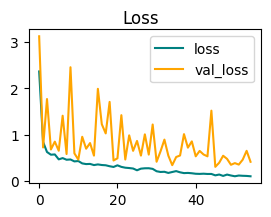

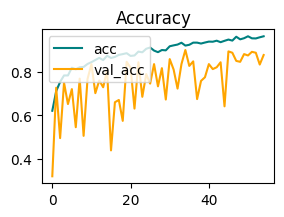

In [24]:
# PLOTTING ==================================================
run["fig-train_loss"].upload(plot_loss(hist))
run["fig-train_acc"].upload(plot_acc(hist))

In [25]:
# EVALUATING ==================================================
model = tf.keras.models.load_model(checkpoint_path)

pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
f1_score = F1Score()
for batch in holdout_test_dataset.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    f1_score.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

precision = pre.result().numpy() * 100
recall = rec.result().numpy() * 100
accuracy = c_acc.result().numpy() * 100
f1_s = f1_score.result().numpy() * 100

f1_building = f1_s[0]
f1_plant = f1_s[1]
f1_road = f1_s[2]
f1_vehicle = f1_s[3]

run["eval/ACC/"] = accuracy
run["eval/REC/"] = recall
run["eval/PRE/"] = precision
run["eval/F1-Bld"] = f1_building
run["eval/F1-Plant"] = f1_plant
run["eval/F1-Road"] = f1_road
run["eval/F1-Vhcl"] = f1_vehicle


In [26]:
# PRINTING RESULTS ===========================================
print(f'Fold Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')
print(f'Precision: {precision}  -  Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1Score: Building {f1_building} | Plant {f1_plant} | Road {f1_road} | Vehicle {f1_vehicle}')

Fold Training Time: 0 hour(s) and 45 mins
Precision: 89.72746133804321  -  Recall: 89.16666507720947
Accuracy: 89.3750011920929
F1Score: Building 83.26530456542969 | Plant 93.9271240234375 | Road 95.72649383544922 | Vehicle 84.6153793334961


In [27]:
# SAVE MODEL TO NEPTUNE AI =======================================
model_save_path = f"./models/Final-Model_4-0-1.keras"
model.save(model_save_path)
run['/checkpoint/model'].upload(model_save_path)
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [ ]:
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING

In [ ]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_blds = []
f1_plants = []
f1_roads = []
f1_vhcls = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    cat_y = tf.keras.utils.to_categorical(train_y)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    c_acc = CategoricalAccuracy()
    f1_score = F1Score()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        f1_score.update_state(y, yhat)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        c_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(c_acc.result().numpy() * 100)
    f1_s = f1_score.result().numpy() * 100
    
    f1_blds.append(f1_s[0])
    f1_plants.append(f1_s[1])
    f1_roads.append(f1_s[2])
    f1_vhcls.append(f1_s[3])
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1-Bld"] = f1_blds[counter]
    run["eval/F1-Plant"] = f1_plants[counter]
    run["eval/F1-Road"] = f1_roads[counter]
    run["eval/F1-Vhcl"] = f1_vhcls[counter]

    # SAVE MODEL TO NEPTUNE AI =======================================
    model_save_path = f"./models/V4-1-3_Fold-{counter}.keras"
    model.save(model_save_path)
    run['/checkpoint/model'].upload(model_save_path)
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: Building {f1_blds[counter]} | Plant {f1_plants[counter]} | Road {f1_roads[counter]} | Vehicle {f1_vhcls[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes